## A large portion of this code is taken from Aurélien Géron's: Hands-On machine learning with SciKit-Learn, Keras and Tensorflow (2nd edition). I have put comments based on information in the book as well as information I found elsewhere. Especially notes on Leslie Smith's Disciplined approach to Hyper-parameter tuning paper.

## Chapter 10

In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [322]:
np.random.seed(42)  # This is done here so we can have consistent results each time we run
                    # any ML code that uses random values.
                    # The Classifier's fit method would not converge for many values of the random seed.
                    # It did converge for random seed 42.
                    # Maybe this needs to be considered as a hyper-parameter?
                    # There are two schools of thought on random seed as a hyperparameter:
                    #   - If you're selecting a seed that gives a better output, then this is overfitting.
                    #     Don't do it - instead keep using the same seed for all your work.
                    #     The seed is only to make sure you can re-create your results.
                    #   - Since the seed can cause model parameters to be very different, use many seeds
                    #     and then use model averaging (bagging, Bayesian methods) to find your final result.

from tensorflow import keras  # Keras needs to be imported after the random seed is set

In [323]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [324]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [325]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Build a Classification MLP using the Sequential API

## One way to create an MLP

In [326]:
model = keras.models.Sequential()    # Creates a stack of layers connected sequentially
model.add(keras.layers.Flatten(input_shape=[28, 28])) # Converts each input image into a 1-D array.
                                                      # Alternatively, use keras.layers.InputLayer with input_shape.
                                                      # It is best to specify the input_shape when creating the model.
                                                      # Without it, you will not be able to do certain things:
                                                      #   - print the model
                                                      #   - save the model
model.add(keras.layers.Dense(300, activation='relu')) # Each dense layer manages:
                                                      #   - Input weights for each neuron
                                                      #   - Bias for each neuron
                                                      # Specifying activation = 'relu' is the same as
                                                      #            activation = keras.activations.relu
                                                      # You can set:
                                                      #   kernel_initializer='random_uniform' to init uniform weights.
                                                      #   bias_initializer=keras.initializers.Constant(0.5)
                                                      #     to initialize constant bias values.
                                                      #     Other initializers: https://keras.io/initializers/
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))  # For binary classification, we would use "sigmoid".

## Alternative way to create an MLP

In [327]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense
# model = Sequential([
#     Flatten(input_shape=[28, 28]),
#     Dense(300, activation='relu'),
#     Dense(100, activation='relu'),
#     Dense(10, activation='softmax')
# ])

## Back to the original program

In [328]:
model.summary()  # In Output Shape, None means the batch size can be anything.
                 # The Param # for each layer includes the bias value for each neuron.
                 # Be careful - with too many Total params, you may overfit,
                 #   especially when you do not have a lot of training data.

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_89 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_90 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [329]:
model.layers

In [330]:
model.layers[1]

In [331]:
model.layers[1].name

'dense_88'

In [332]:
weights, biases = model.layers[1].get_weights()  # You can see that the dense layer:
                                                 #   - initialized the weights randomly
                                                 #   - set the bias values all to 0
weights

array([[-0.0678383 , -0.06511151,  0.01639272, ..., -0.02119127,
        -0.04947909, -0.03463744],
       [ 0.01643627,  0.05512643,  0.05640866, ...,  0.03617733,
        -0.05592082,  0.06672546],
       [-0.02711286, -0.06604952, -0.01993814, ...,  0.01279791,
        -0.00254992, -0.05866556],
       ...,
       [-0.00930109,  0.02307093, -0.0137771 , ..., -0.03926386,
         0.02513287, -0.02407587],
       [ 0.0662652 , -0.03792149,  0.03099465, ...,  0.00127051,
        -0.07028665,  0.05949616],
       [ 0.01872732,  0.02314666,  0.04066293, ...,  0.00541643,
         0.00837556,  0.05962691]], dtype=float32)

In [333]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [334]:
model.compile(loss = 'sparse_categorical_crossentropy',  # Same as loss = keras.losses.sparse_categorical_crossentropy
                                                         #   For each instance we have a target class index from 0-9.
                                                         #   This is why we use sparse_categorical_crossentropy.
                                                         #   If we had multiple target values (ex. one-hot encoded),
                                                         #   we would use "categorical_crossentropy".
                                                         #   For binary classification, 
                                                         #     we would use "binary_crossentropy".
                                                         # Sparse labels -> on-hot encoding: 
                                                         #   Use keras.utils.to_categorical()
                                                         # One-hot encoded -> Sparse labels:
                                                         #   Use np.argmax(labels_array, axis=1)
              optimizer=keras.optimizers.SGD(lr=0.001),          # We could have used optimizer='sgd' here, but that would
                                                         #   mean we want to use the default learning rate of 0.01.
              metrics=['accuracy'])                      # Same as metrics = keras.metrics.sparse_categorical_accuracy
                                                         # We want to measure accuracy since this is a classifier.

In [335]:
history = model.fit(X_train, y_train, epochs=30,         # By default, epochs = 1, so we have to set it.
                    validation_data=(X_valid, y_valid))  # Instead of passing in validation data, we can say
                                                         #   use the last 10% of the training dataset
                                                         #   (before shuffling). Use validation_split=0.1
                                                         # If the training set was skewed with some classes
                                                         #   represented more than others, we can use
                                                         #   class_weight={0: 0.25, 1: 0.75} Pay more attention to
                                                         #   class index 1 since it is under-represented by a third.
                                                         #   To find this sampling:
                                                         #     from sklearn.utils import class_weight
                                                         #     class_weights = class_weight.compute_class_weight(
                                                         #                                     'balanced',
                                                         #                                     np.unique(y_train),
                                                         #                                     y_train)
                                                         # If some of your samples are better (maybe labeled
                                                         #   by experts), compared to others, pass a list of
                                                         #   sample weights (same length as the # of instances).
                                                         #   You can also provide sample weights to the validation
                                                         #   set by adding them to the validation_data as the third
                                                         #   value in the tuple.

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 5s 96us/sample - loss: 2.4947 - accuracy: 0.7023 - val_loss: 0.6735 - val_accuracy: 0.7696
Epoch 2/30
55000/55000 [==============================] - 5s 88us/sample - loss: 0.6096 - accuracy: 0.7795 - val_loss: 0.6106 - val_accuracy: 0.7918
Epoch 3/30
55000/55000 [==============================] - 5s 88us/sample - loss: 0.5333 - accuracy: 0.8069 - val_loss: 0.5885 - val_accuracy: 0.7980
Epoch 4/30
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4892 - accuracy: 0.8218 - val_loss: 0.5471 - val_accuracy: 0.7998
Epoch 5/30
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4570 - accuracy: 0.8317 - val_loss: 0.5100 - val_accuracy: 0.8290
Epoch 6/30
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4351 - accuracy: 0.8395 - val_loss: 0.5016 - val_accuracy: 0.8292
Epoch 7/30
55000/55000 [==============================] -

In [336]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [337]:
history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [338]:
history.history

{'loss': [2.494653049954501,
  0.6096252626809207,
  0.5333447215643796,
  0.4892303782268004,
  0.45703483397960665,
  0.4350739197319204,
  0.41633614401383834,
  0.4012707374009219,
  0.3871718672102148,
  0.3774702596664429,
  0.36595164047154516,
  0.35684412865205245,
  0.3492423272761432,
  0.34054042740084906,
  0.334789712416042,
  0.32831505175937303,
  0.3231516717152162,
  0.318667080710151,
  0.31340096809430557,
  0.30985519948222423,
  0.30587878866629165,
  0.3018668862364509,
  0.29804141725410116,
  0.2960583545608954,
  0.2905281115358526,
  0.28796229957884006,
  0.2853754802010276,
  0.2824975565390153,
  0.27887369915463706,
  0.2757551206111908],
 'accuracy': [0.70225453,
  0.7794545,
  0.80694544,
  0.8217818,
  0.83172727,
  0.8394727,
  0.8438909,
  0.8492909,
  0.8562545,
  0.8593636,
  0.86216366,
  0.8650727,
  0.8680364,
  0.8722,
  0.8739091,
  0.8766909,
  0.8784182,
  0.8796545,
  0.88183635,
  0.8828909,
  0.8852909,
  0.8865455,
  0.8885091,
  0.88898

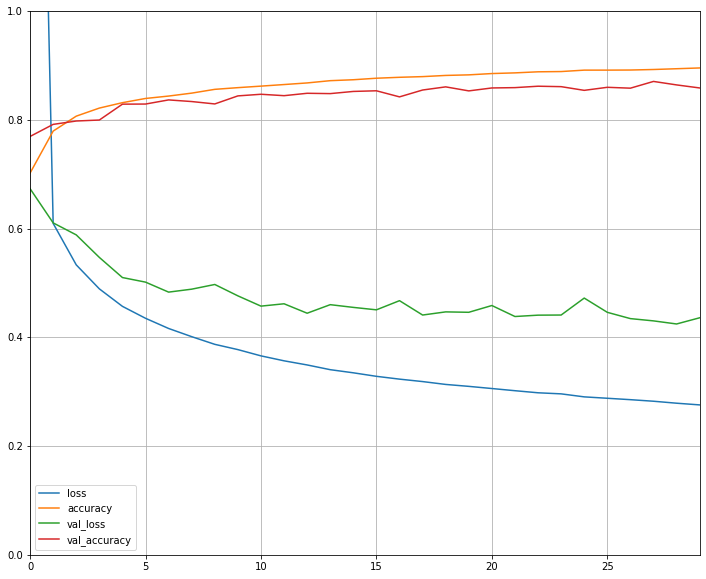

In [339]:
pd.DataFrame(history.history).plot(figsize=(12, 10))  # Ideally, we would like to see decreasing loss values
                                                      # and increasing accuracy.
                                                      # Since the ML libraries use random numbers, it can result
                                                      # in different output.
                                                      # We can tell if the model has converged based on the error curves.
                                                      # The validation error is computed at the end of each epoch,
                                                      # and the training error is computed during each epoch.
                                                      # This is why the training curve should be shifted half an epoch
                                                      # to the left.
                                                      # If you want to continue training, call the fit() method again.
                                                      # It will continue where it left off.
                                                      # Tuning:
                                                      #   Tune the learning rate first.
                                                      #   Then try another optimizer.
                                                      #   Tune each hyperparameter. For each hyperparameter, retune
                                                      #     the learning rate.
                                                      #   Then try tuning the model parameters:
                                                      #     - Number of layers
                                                      #     - Neurons per layer
                                                      #     - Activation functions per layer
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [340]:
loss_value, metrics = model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [341]:
loss_value, metrics

(0.47630434359312057, 0.8525)

In [342]:
X_new, y_new = X_test[:3], y_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [343]:
y_pred = model.predict_classes(X_new)
y_pred, y_new

(array([9, 2, 1]), array([9, 2, 1], dtype=uint8))

In [344]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

# Build a Regression MLP using the Sequential API

In [345]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
                            housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(
                            X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [346]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='sgd')

In [347]:
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 121us/sample - loss: 0.8414 - val_loss: 0.5615
Epoch 2/20
11610/11610 [==============================] - 0s 43us/sample - loss: 0.5029 - val_loss: 0.5177
Epoch 3/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5525 - val_loss: 0.4964
Epoch 4/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4605 - val_loss: 0.4666
Epoch 5/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4559 - val_loss: 0.4630
Epoch 6/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4417 - val_loss: 0.4515
Epoch 7/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4288 - val_loss: 0.4377
Epoch 8/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4179 - val_loss: 0.4332
Epoch 9/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4105 - val_

In [348]:
print(f'y_pred: {y_pred.flatten().round(2)}\ny_new:  {y_new.flatten().round(2)}')

y_pred: [0.72 1.66 3.63]
y_new:  [9 2 1]


# Building complex models with the functional API
A Wide and Deep Neural Network consists of:
  - A deep section that connects the inputs to the outputs through layers.
    This allows the network to learn complex rules.
  - A wide section that connects the inputs directly to the outputs.
    This allows the network to learn simple rules.

In [349]:
input_  = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)  # We call each layer like a function passing it the
                                                             # needed layer below it. This is why it's called
                                                             # the functional API.
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.Concatenate()([input_, hidden2])      # Input layer directly connecting to the output layer
                                                             # makes this a wide network.
                                                             # Having more than one hidden layer makes it deep.
output  = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

# After this, the model is trained, evaluated, and used to predict as before. So we don't show that here.

What if you wanted some features to go through the wide path,
and some through the deep path? Let's do that now:

In [350]:
input_A = keras.layers.Input(shape=[5], name='wide_input')    # We will send 5 features through the wide path.
input_B = keras.layers.Input(shape=[6], name='deep_input')    # We will send 6 features through the deep path.
                                                              # You should name the most important layers,
                                                              # especially when the model gets as complicated as this.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.concatenate([input_A, hidden2])
output  = keras.layers.Dense(1, name='output')(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [351]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]  # Data must have 8 columns. 
                                                       # This is why when we say 2: columns 2,3,4,5,6,7 are specified.
                                                       # This is correct since we need 6 columns for input b.
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A,  X_test_B  = X_test[:, :5],  X_test[:, 2:]
X_new_A,   X_new_B   = X_test_A[:3],   X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 79us/sample - loss: 2.1633 - val_loss: 0.9623
Epoch 2/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.8438 - val_loss: 0.7519
Epoch 3/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.7101 - val_loss: 0.6830
Epoch 4/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6555 - val_loss: 0.6473
Epoch 5/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6226 - val_loss: 0.6231
Epoch 6/20
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5984 - val_loss: 0.6027
Epoch 7/20
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5793 - val_loss: 0.5861
Epoch 8/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5633 - val_loss: 0.5747
Epoch 9/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5500 - val_l

In [352]:
print(f'y_pred: {y_pred.flatten().round(2)}\ny_new:  {y_new.flatten().round(2)}')

y_pred: [0.71 1.8  2.83]
y_new:  [9 2 1]


Sometimes, you may need multiple outputs:
  - ex. You need to locate and classify the main picture in an image.
        The location will be xy coords, and a bounding rectangle.
        The classification will be another output.
        So now we have x coord, y coord, width, height, classification as outputs
  - Multiple independent tasks are needed on the same data.
    You will get better results training a single network because the network
    can learn features across tasks.
  - As a regularization technique, you may want to add auxiliary output to one of the inner layers
    to see if it is doing it's job.

In [353]:
input_A = keras.layers.Input(shape=[5], name='wide_input')    # We will send 5 features through the wide path.
input_B = keras.layers.Input(shape=[6], name='deep_input')    # We will send 6 features through the deep path.
                                                              # You should name the most important layers,
                                                              # especially when the model gets as complicated as this.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.concatenate([input_A, hidden2])
output  = keras.layers.Dense(1, name='output')(concat)
# The above code is the same as earlier.

aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(loss=['mse', 'mse'], # Each output function needs it's own loss. 1st loss fn corresponds to 1st output?
              loss_weights=[0.9, 0.1], # We can give weights to each of the losses. Else Keras just adds the losses.
              optimizer='sgd')

history = model.fit(
                (X_train_A, X_train_B),
                (y_train, y_train),    # Both outputs need the labels (y-values). Since they should predict the same
                                       # thing, they're the same labels.
                epochs = 20,
                validation_data=([X_valid_A, X_valid_B], 
                                 [y_valid, y_valid]))  # Again, we need labels for both outputs here.

total_loss, main_loss, aux_loss = model.evaluate(  # Keras returns the total loss + the individual losses.
                [X_test_A, X_test_B],
                [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])  # We will get predictions for each output.

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 101us/sample - loss: 1.5663 - output_loss: 1.4965 - aux_output_loss: 2.1891 - val_loss: 0.6982 - val_output_loss: 0.6350 - val_aux_output_loss: 1.2658
Epoch 2/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5613 - output_loss: 0.5042 - aux_output_loss: 1.0750 - val_loss: 0.5499 - val_output_loss: 0.5019 - val_aux_output_loss: 0.9809
Epoch 3/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5100 - output_loss: 0.4701 - aux_output_loss: 0.8709 - val_loss: 0.5054 - val_output_loss: 0.4697 - val_aux_output_loss: 0.8260
Epoch 4/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4606 - output_loss: 0.4300 - aux_output_loss: 0.7355 - val_loss: 0.4662 - val_output_loss: 0.4355 - val_aux_output_loss: 0.7413
Epoch 5/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.4385 - output_loss: 0.4

In [354]:
y_new_A, y_new_B = y_test[:3], y_test[:3]
print(f'y_pred_main: {y_pred_main.flatten().round(2)}\ny_new_A:     {y_new_A.flatten().round(2)}')
print(f'y_pred_aux:  {y_pred_aux.flatten().round(2)}\ny_new_B:     {y_new_B.flatten().round(2)}')

y_pred_main: [0.55 1.32 3.61]
y_new_A:     [0.48 0.46 5.  ]
y_pred_aux:  [0.65 1.65 2.75]
y_new_B:     [0.48 0.46 5.  ]


# Using the subclassing API to build Dynamic Models

Both the Sequential an Functional APIs are declarative. Advantages of this are:
  - model can be easily saved, cloned, shared
  - model structure can be displayed and analyzed
  - framework can infer shapes and check types (for error checking)
  - easy to debug
  
Some models involve:
  - loops
  - varying shapes
  - conditional branching

For these models, you can use the Subclassing API

In [355]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(kwargs) # handles standard args - ex. name
        self.hidden1 = keras.layers.Dense(units, activation=activation)  # Create the layers in the constructor
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output  = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)  # Use the layers as you want in the call() function.
                                         # In this call() function, you can use 
                                         #   - for loops
                                         #   - if statements
                                         #   - low-level tensorflow operations
                                         # This is very useful for researchers experimenting with new ideas.
        hidden2 = self.hidden2(hidden1)
        concat  = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)

# This WideAndDeepModel provides the same functionality as the functional API.
# You can compile it, evaluate it, and make predictions as was done earlier.
# Cost:
#   - Model architecture is hidden within the call() method, so Keras cannot save/clone it.
#   - summary() returns just a list of layers but not how they're connected to each other.
#   - Keras cannot check types/shapes ahead of time.

In [356]:
# Any Keras Model can be used just like a layer.
# You can easily combine them to build complex architectures.

# Saving and Restoring a Model

In [357]:
model_dir = './data'
model_filename = os.path.join('.', model_dir, 'my_keras_model.h5')

model.save(model_filename)       # Saves the model in the HDF5 format, including:
                                 #   - the model architecture
                                 #   - each layer's parameters
                                 #   - connection weights and biases
                                 #   - the optimizer, it's parameters, and it's state.
                                 # This will not work when using model subclassing. For subclassing,
                                 #   you can use save_weights() and load_weights(), but you need to
                                 #   save and restore everything else yourself.

In [358]:
model = keras.models.load_model(model_filename)

In [359]:
model

# Using Callbacks

In [362]:
# Training can take hours sometimes, and your computer may crash.
# You should save your model at intervals while it is training using callbacks.
# Let's build the model using the functional API and use callbacks in fit().

input_  = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)  # We call each layer like a function passing it the
                                                             # needed layer below it. This is why it's called
                                                             # the functional API.
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.Concatenate()([input_, hidden2])
output  = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
                    model_filename,
                    save_best_only=True)       # If you specify validation set, save_best_only=True saves only if the
                                               # current model is better on the validation set than the earlier models.

model.compile(loss=['mse'], loss_weights=[0.9], optimizer='sgd')

history = model.fit(X_train, y_train, epochs=10, 
                    callbacks=[checkpoint_cb], # Saves model at the end of each epoch
                    validation_data=(X_valid, y_valid))
model = keras.models.load_model(model_filename) # Load the best model that was saved during the fit()

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 74us/sample - loss: 0.8954 - val_loss: 0.5567
Epoch 2/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4560 - val_loss: 0.5151
Epoch 3/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.6787 - val_loss: 0.4829
Epoch 4/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4054 - val_loss: 0.4284
Epoch 5/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4563 - val_loss: 0.4176
Epoch 6/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.3827 - val_loss: 0.4367
Epoch 7/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5227 - val_loss: 0.4053
Epoch 8/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4079 - val_loss: 0.3886
Epoch 9/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3555 - val_l

In [364]:
# Combine early stopping and checkpoint callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, # Stops if the model is not getting better on the
                                                               # validation set for the last 10 epochs
                                                               # (as given by patience).
                                                  restore_best_weights=True) # After training is done, roll back
                                                                             # to the best weights for the model.
history = model.fit(X_train, y_train, epochs=100,  # The number of epochs can be large since we're stopping early.
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # Saves model at the end of each epoch (checkpoints)
                                                                  # and interrupts training if there is no progress.

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3448 - val_loss: 0.3827
Epoch 2/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.3446 - val_loss: 0.4119
Epoch 3/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4669 - val_loss: 0.3997
Epoch 4/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3405 - val_loss: 0.3926
Epoch 5/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4602 - val_loss: 0.3721
Epoch 6/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.3320 - val_loss: 0.4480
Epoch 7/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.7175 - val_loss: 0.3793
Epoch 8/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4700 - val_loss: 0.3581
Epoch 9/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.317

In [365]:
# Create your own callback
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('val/train: {:.2f}'.format(logs['val_loss'] / logs['loss']))

In [366]:
# Callbacks during fit():
#   on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), on_batch_begin(), and on_batch_end().
# Callbacks during evaluate():
#   on_test_begin(), on_test_end(), on_test_batch_begin(), or on_test_batch_end()
# Callbacks during predict():
#   on_predict_begin(), on_predict_end(), on_predict_batch_begin(), or on_predict_batch_end()

# Using TensorBoard for Visualization

In [367]:
# TensorBoard allows you to:
#   - View learning curves during training
#   - Compare learning curves between multiple runs
#   - Visualize the computation graph
#   - Analyze training statistics
#   - View images generated by your model
#   - View complex multi-dimensional data projected down to 3-D, and automatically clustered for you
# You must output the data to event files (special binary log files).
# Point the TensorBoard server to the root of the log directories.
# Configure your code to write to a different subdirectory each time it runs.

import os 
root_logdir = os.path.join(os.curdir, "my_logs") 

def get_run_logdir (): 
    import time 
    run_id = time.strftime("run_%Y_%m_%d%H_%M_%S") 
    return os.path.join(root_logdir , run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22' 

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs = 30, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[tensorboard_cb]) 

# Then start the tensorboard server:
#   tensorboard --logdir=./my_logs --port=6006
# Open browser at localhost:6006
# To use tensorboard directly within Jupyter notebook:
#   %load_ext tensorboard 
#   %tensorboard logdir=./my_logs port=6006 
#
# Tensorflow also offers a lower-level API in the tf.summary package.
# It allows you to log extra data, such as embeddings.

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 48us/sample - loss: 0.2780 - val_loss: 0.3235
Epoch 2/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.2782 - val_loss: 0.3443
Epoch 3/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3689 - val_loss: 0.3487
Epoch 4/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.2821 - val_loss: 0.3481
Epoch 5/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4302 - val_loss: 0.3170
Epoch 6/30
11610/11610 [==============================] - 1s 48us/sample - loss: 0.2777 - val_loss: 0.3996
Epoch 7/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.6877 - val_loss: 0.3391
Epoch 8/30
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4386 - val_loss: 0.3061
Epoch 9/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.2707 - val_l

# Notes for: Lislie Smith's "Disciplined approach to Neural Network Hyper-parameters"
https://arxiv.org/abs/1803.09820

  - Generalization error = Validation Loss - Training Loss
  - We need to see validation loss keep decreasing as model complexity increases. This is where we're underfitting.
    At some point the validation loss starts increasing with model complexity. This is where we're overfitting.
    The point at which validation loss is lowest (derivative of validation loss = 0) is the optimal point.
  - Use only a few epochs to select hyperparameters. Signs of underfitting or overfitting early in the 
    training process can be used to select hyperparameters. You don't need to run through a large number of epochs.
    This also saves you a lot of time.
  - LR Range test to choose a maximum LR value.
    ```
    pre_training_delta = 0.1  # You may have to change this if there is no convergence
    for lr in range(0.01, 3.01, pre_training_delta):
      Train the network, and see the test loss.
      For smaller lr, the test error will keep going lower.
      Find the lr value at which the test error starts going up.
      This is your maximum lr range value (max_lr)
    ```
  - Choosing a minimum LR value using either:
    - min_lr = max_lr/4 (if you're using multiple cycles)
    - min_lr = max_lr/20 (if you're using a single cycle)
    - Find the largest min_lr that converged the network
      ```
      min_lr = 50
      for lr in range(0.01, 0.5, pre_training_delta):
        for iter in range(300):
          if network converged and (min_lr > lr):
            min_lr = lr
      so min_lr = maximum value of starting lr that converged the network.
      ```
  - CLR (Cyclical Learning Rate):
    - Choose the number of cycles (num_cycles)
    - Choose a number of iterations, called step size (say step_size = 100)
    - Choose a training_delta
      training_delta = 0.01
    - CLR:
      ```
      for _ in range(num_cycles):
        for iter in range(step_size):
          for lr in range(min_lr, max_lr + 0.0001, training_delta):
            Run the network and see the test loss
        for iter in range(step_size):
          for lr in range(max_lr, min_lr - 0.0001, -training_delta):
            Run the network and see the test loss
      ```
    - Note that there is a maximum speed at which the learning rate can increase
      without the training becoming unstable.
  - Superconvergence: When the test loss (and thus test accuracy) remain constant even with large LR values.
    - Using such large values:
      - You converge faster
      - You're regularized already (due to the large LR values).
    - For superconvergence, the CLR should be changed like this (I think, check the paper to make sure):
      ```
      # One cycle should be smaller than the total number of iterations/epochs
      step_size_multiplier = 0.3
      for _ in range(1):
        for iter in range(step_size * step_size_multiplier):
          for lr in range(min_lr, max_lr + 0.0001, training_delta):
            Run the network and see the test loss
        for iter in range(step_size * step_size_multiplier):
          for lr in range(max_lr, min_lr - 0.0001, -training_delta):
            Run the network and see the test loss
      
      # minimum LR should be several orders of magnitude smaller for
      # these remaining cycles
      min_lr_multiplier = 0.01
      for _ in range(num_cycles):
        for iter in range(step_size):
          for lr in range(min_lr * min_lr_multiplier, max_lr + 1e-10, training_delta):
            Run the network and see the test loss
        for iter in range(step_size):
          for lr in range(max_lr, min_lr * min_lr_multiplier - 1e-10, -training_delta):
            Run the network and see the test loss
      ```
      - Use a larger batch size when using 1cycle learning rate schedule.
    - When using large LR values, we need to balance those with reducing other forms of regularization.
      This principle will allow us to use superconvergence for many datasets.
    - Look at the test loss to see if we're converging
    - batch/mini-batch = size of data given to the network at a time.
    - iteration = one forward pass + one backward pass for one batch/mini-batch
    - epoch = one forward pass + one backward pass through the entire training dataset
    - number of iterations = number of batches in the whole dataset
    - In superconvergence:
      - One benefit of large learning rate is regularization without overfitting
    - Learning rate:
      - A large learning rate allows the network to change it's mind quickly. Ex. If a network has been trained with orange cats to identify cats, a black cat may not be identified. With a large learning rate, the network quickly learns that black cats are also cats.
      - Too large a learning rate can allow a network to think that recent samples (black cats) are the only cats. i.e it forgets the older orange cats samples.
    - Batch size:
      - Changing batch size changes execution time, so we should try to get the largest batch size that converges, in a given execution time
      - Select a small batch size and run til stopping. Record the amount of time needed.
      - Run for the same amount of time with larger batch sizes (plot the average validation loss over 4 runs average per batch size). New batch size = earlier batch size * 2
      - Plot the average validation loss over 4 runs for each batch size on the same plot so you can see relative losses between batch sizes. Do the same for validation accuracy.
      - Pick the second-to-largest batch size where we converge
      -  We use the execution time as a stopping criteria, because as you change the batch size, you have to change the number of iterations, or the epochs. Otherwise, the number of times you're changing the weights of your network for each batch size is different, so it is not an apples to apples comparison
      - The 4 runs are needed to ensure we're not acting on one result that is not reproducible (result was good/bad due to randomness).
      - Some have suggested that you changed batch size first. Remember, batch size is related to the amount of memory you have. If you don't have unlimited amounts of memory, stick with changing learning rate first, and then batch size. This way your batch sizes will be moderate.
    - Cyclical momentum
      - Momentum and learning rate are closely related.
      -  A large value of momentum allows a network to jump over local minima, this making it possible to get to the focal minima.
      - To large a value of momentum could jump it across the global minima, thus never converging, or converging to a local minima
      - We want to see momentum as high as possible without causing instabilities
      - The effect of momentum on updating the weights is there same as that of the learning rate
      - A decreasing momentum will allow increasing learning rates. It can also lead to:
        - Lower test loss
        - Faster initial convergence
        - Greater stability over a larger range of learning rates
        - Cyclical learning rates + cyclical momentum works best.
      - If a constant learning rate is used, a large momentum (0.9-0.99) will accelerate training. But too large a momentum causes poor training results. So if you're using a constant learning rate, start with a large momentum and decrease it if you see poor results.
    - When looking at test loss vs. learning rate, a curve that goes down and then slants up, then diverges, implies overfitting. A curve that goes down and then jumps up shows divergence
    - Weight decay
      - Cyclical weight decay is not useful. Use the best value, and keep it constant throughout training.
      - A good procedure is to simultaneously change CLR, and CM with particular values of weight decay. Try with 1e-3, 1e-4, 1e-5, and 0 (for larger datasets).
      - Larger datasets require a smaller value (probably because the dataset is complicated enough to not require additional regularization). Smaller datasets require a larger value.
      - For smaller datasets, use values 1e-2, 1e-3, 1e-4
      - Once you find a good value, bisect it's exponent. ex. If 1e-4 is the value, use 3e-5, 1e-4, and 3e-4 (because 1e-3.5 = 3.16e-4).
      - If you're using fixed values of learning rate and momentum, you could pick a weight decay by:
        - Running a test loss vs. learning rate at a particular weight decay value.
        - Save a snapshot at the divergence point
        - Select different learning rates and run the same model from the divergence point
        - This will save you processing time
